In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import zipfile
import io
import os
import time
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer

C:\Users\Majid\anaconda3\envs\LLM\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
tsv_filename = "SMSSpamCollection"


def download_extract_read_tsv(url, tsv_filename, extract_to="sms_spam_collection"):
    """
    Download a zip file from `url`, extract it, and read a .tsv file inside.

    Args:
        url (str): URL of the zip file
        tsv_filename (str): Name of the .tsv file inside the zip
        extract_to (str): Directory to extract files to

    Returns:
        pandas.DataFrame: The loaded TSV file
    """
    # Download the zip file
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: Status code {response.status_code}")
    
    # Extract the zip file
    os.makedirs(extract_to, exist_ok=True)
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"Extracted files to '{extract_to}'")
    
    # Read the .tsv file
    file_path = os.path.join(extract_to, tsv_filename)
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{tsv_filename} not found in extracted files")
    
    data = pd.read_csv(file_path, sep='\t')
    print(f"Loaded TSV file '{tsv_filename}' successfully")
    return data, file_path
    
data, file_path = download_extract_read_tsv(url, tsv_filename)
print(data.head())

Extracted files to 'sms_spam_collection'
Loaded TSV file 'SMSSpamCollection' successfully
    ham  \
0   ham   
1  spam   
2   ham   
3   ham   
4  spam   

  Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...  
0                      Ok lar... Joking wif u oni...                                                               
1  Free entry in 2 a wkly comp to win FA Cup fina...                                                               
2  U dun say so early hor... U c already then say...                                                               
3  Nah I don't think he goes to usf, he lives aro...                                                               
4  FreeMsg Hey there darling it's been 3 week's n...                                                               


In [3]:
df = pd.read_csv(
    file_path, sep='\t', header=None, names=['Label', 'Text']
)
df.head()

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
"""
    This function creates a balanced dataset by undersampling the majority class.
"""

def create_balanced_dataset(df):
    # 1. Count the number of spam messages
    num_spam = df[df['Label'] == 'spam'].shape[0]  

     # 2. Randomly sample the same number of ham messages as spam
    ham_subset = df[df['Label'] == 'ham'].sample(
        num_spam,          # Sample this many ham messages
        random_state=123   # For reproducible results
    )     

     # 3. Combine the sampled ham messages with all spam messages
    balanced_df = pd.concat([
        ham_subset,                 # The randomly selected ham messages
        df[df['Label'] == 'spam']   # All spam messages
    ])         
    
    return balanced_df

# 4. Apply the function and check the balance
balanced_df = create_balanced_dataset(df)
print(balanced_df['Label'].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


In [5]:
balanced_df['Label'] = balanced_df['Label'].map({'ham': 0, 'spam': 1})
balanced_df.head()

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?


In [6]:
"""
    This function performs a random split of a dataset into training, validation, and test sets.
"""


def random_split(df, train_frac, validation_frac):

    # 1. Shuffle the dataframe randomly
    df = df.sample(
        frac=1,                 # Sample 100% of rows (shuffle)
        random_state=123        # For reproducible shuffling
    ).reset_index(drop=True)    # Reset index to avoid old index issues


    # 2. Calculate split points
    train_end = int(len(df) * train_frac)                          # End index for training set
    validation_end = train_end + int(len(df) * validation_frac)    # End index for validation set

    
    # 3. Split the dataframe
    train_df = df[:train_end]                           # First portion: training set
    validation_df = df[train_end:validation_end]        # Middle portion: validation set
    test_df = df[validation_end:]                       # Last portion: test set

    return train_df, validation_df, test_df

# 4. Usage example
train_df, validation_df, test_df = random_split(
    balanced_df, 0.7, 0.1)                              # 70% train, 10% validation, 20% test

In [7]:
# save the dataset as CSV (comma-separated value) files so we can reuse it later:

train_df.to_csv('train.csv', index=None)
validation_df.to_csv('validation.csv', index=None)
test_df.to_csv('test.csv', index=None)

In [8]:
tokenizer = tiktoken.get_encoding('gpt2')
print(tokenizer.encode('<|endoftext|>', allowed_special={'<|endoftext|>'}))

[50256]


In [9]:
# Creating data loaders

class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None,
                 pad_token_id=50256):

         # 1. Load and tokenize the data
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data['Text']
        ]

        # 2. Handle sequence length
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            # Truncate sequences that are too long
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 3. Pad sequences to uniform length
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]


    def __getitem__(self, index):
        # Return one data sample (text + label)
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]['Label']
        return (
            torch.tensor(encoded, dtype=torch.long),        # Input tokens
            torch.tensor(label, dtype=torch.long)           # Target label
        )

    def __len__(self):
        return len(self.data)                  # Total number of samples

    
    # Helper method to find the longest sequence
    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


In [10]:
train_dataset = SpamDataset(
    csv_file='train.csv',
    max_length=None,
    tokenizer=tokenizer
)
val_dataset = SpamDataset(
    csv_file='validation.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file='test.csv',
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

In [11]:
print("Maximum lenght of a text in the whole dataset: ", train_dataset.max_length)
print("Lenght of train dataset: ", len(train_dataset))
print("Lenght of validation dataset: ", len(val_dataset))
print("Lenght of test dataset: ", len(test_dataset))

Maximum lenght of a text in the whole dataset:  120
Lenght of train dataset:  1045
Lenght of validation dataset:  149
Lenght of test dataset:  300


In [12]:
"""
    This code creates DataLoader objects for training, validation, and test datasets.
"""
# 1. Configuration settings
num_workers = 0              # Number of subprocesses for data loading
batch_size = 8               # Number of samples per batch
torch.manual_seed(123)       # For reproducible randomness

train_loader = DataLoader(
    dataset=train_dataset,    # Training dataset
    batch_size=batch_size,    # 8 samples per batch
    shuffle=True,             # Shuffle data each epoch
    num_workers=num_workers,  # 0 = load in main process
    drop_last=True,           # Drop last incomplete batch
)
val_loader = DataLoader(      
    dataset=val_dataset,      # Validation dataset
    batch_size=batch_size,    # Same batch size
    num_workers=num_workers,  # 0 workers
    drop_last=False,          # Keep incomplete batches
)
test_loader = DataLoader(
    dataset=test_dataset,      # Test dataset
    batch_size=batch_size,     # Same batch size
    num_workers=num_workers,   # 0 workers
    drop_last=False,           # Keep incomplete batches
)


In [13]:
print(f'{len(train_loader)} training batches')
print(f'{len(val_loader)} validation batches')
print(f'{len(test_loader)} test batches')

130 training batches
19 validation batches
38 test batches


In [14]:
# Initializing a model with pretrained weights
CHOOSE_MODEL = 'gpt2-small (124M)'
INPUT_PROMPT = 'Every effort moves'
BASE_CONFIG = {
    'vocab_size': 50257,          #1
    'context_length': 1024,       #2
    'drop_rate': 0.0,             #3
    'qkv_bias': True              #4
}
model_configs = {
    'gpt2-small (124M)': {'emb_dim': 768, 'n_layers': 12, 'n_heads': 12},
    'gpt2-medium (355M)': {'emb_dim': 1024, 'n_layers': 24, 'n_heads': 16},
    'gpt2-large (774M)': {'emb_dim': 1280, 'n_layers': 36, 'n_heads': 20},
    'gpt2-xl (1558M)': {'emb_dim': 1600, 'n_layers': 48, 'n_heads': 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [15]:

# 1. Choose model size
model_name = "gpt2"  # Options: "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"

# 2. Load pre-trained model and tokenizer
# from_pretrained(): Downloads pre-trained weights from Hugging Face
tokenizer = GPT2Tokenizer.from_pretrained(model_name)  # Converts text to numbers (tokens) and back
model = GPT2LMHeadModel.from_pretrained(model_name)    # The actual GPT-2 model with language modeling head

# 3. Set padding token
"""
    Problem: Original GPT-2 doesn't have a dedicated padding token
    Solution: Use the end-of-sequence (<|endoftext|>) token for padding
    Why: Needed for batch processing with sequences of different lengths
"""
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token  # Use end-of-sequence token for padding
    print("Set pad_token to eos_token.")

# 4. Set device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # Move model to appropriate device

# 5. Put model in evaluation mode
model.eval()
print("Model and tokenizer loaded successfully!")

Set pad_token to eos_token.
Model and tokenizer loaded successfully!


In [16]:
"""
    This code implements a greedy text generation algorithm using a GPT-style model.
"""

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # Loop for generating new tokens
    for _ in range(max_new_tokens):
        # 1. Truncate to context window
        idx_cond = idx[:, -context_size:]
        
        # 2. Get model predictions (no gradients for efficiency)
        """
            - When you pass it through a GPT-2 model (or any GPT2LMHeadModel), 
            - the model returns a CausalLMOutputWithCrossAttentions object, which has several attributes:
            - print(output.keys())
              -e.g. dict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])

            - output.logits is what we usually care about for predictions.
        """
        with torch.no_grad():
            output = model(idx_cond)      # Forward pass through the model
            logits = output.logits        # Raw prediction scores for each token in vocabulary
        
        # 3. Focus on Last Token
        logits = logits[:, -1, :]  # Shape: [batch_size, vocab_size] 
        
        # 4. Convert logits to probabilities
        probas = torch.softmax(logits, dim=-1)
        
        # 5. Greedy sampling: choose most likely token
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        # 6. Append new token to sequence
        idx = torch.cat((idx, idx_next), dim=1)
    
    return idx

In [17]:
# We can implement the text generation process, as shown in the following listing.
def text_to_token_ids(text, tokenizer):
    #Converts a text string to a tensor of token IDs.
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    #Converts token IDs back to text.
    flat = token_ids.squeeze(0)                # Remove batch dimension
    return tokenizer.decode(flat.tolist())

In [18]:
text_1 = ("Is the following text 'spam'? Answer with 'yes' or 'no'")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG['context_length']
)
print(token_ids_to_text(token_ids, tokenizer))

Keyword arguments {'allowed_special': {'<|endoftext|>'}} not recognized.


Is the following text 'spam'? Answer with 'yes' or 'no'

Spam is a common problem in the Internet age. It is a form of spam that is used to


In [19]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)


In [20]:
# This code freezes all the parameters of a PyTorch model
for param in model.parameters():    # Returns an iterator over all learnable parameters of the model
    param.requires_grad = False     # Freezes the parameter at its current value

In [21]:
# we replace the output layer (model.out_head), which originally maps the layer inputs to 50,257 dimensions, 

torch.manual_seed(123)
num_classes = 2

"""
     * GPT-2 is originally a language model:
        - lm_head is the linear layer that maps the hidden states to the vocabulary logits (for predicting the next token).
        - Original shape: [hidden_size, vocab_size] → e.g., [768, 50257] for gpt2-small.
     * Here, you replace the LM head with a new linear layer:
        - model.config.n_embd → the embedding dimension (hidden size of GPT-2, usually 768 for gpt2-small).
        - 2 → output size = number of classes.

     * The GPT-2 model now outputs 2 logits per token instead of predicting the next word.
     * You can use these logits for binary classification (spam/ham).
"""
model.lm_head = torch.nn.Linear(model.config.n_embd, 2)


"""
    * Updates the GPT-2 configuration to match the new output layer.
    * Without updating it, there could be shape mismatches or warnings.
    * Why? Because some parts of Hugging Face’s code (e.g., generating outputs or calculating loss) rely on config.vocab_size.
"""
model.config.vocab_size = 2  # keep config consistent

In [22]:
print(model)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)


In [23]:
# This code implements partial unfreezing of specific layers in a GPT-2 model for fine-tuning.
"""
    * Why do this? Full GPT-2 has millions of parameters. Fine-tuning all layers can be:
      - Slow
      - Memory-intensive
      - Prone to overfitting with small datasets
      
    * Selective fine-tuning (head + last block + LayerNorm):
      - Reduces the number of trainable parameters.
      - Still allows the model to adapt to your new task (spam/ham classification)
"""


# 1. Unfreeze the language modeling head
"""
    * lm_head is the linear layer we replaced for classification.
    * Setting requires_grad = True ensures the model will train this new output layer, which is essential.
"""
for param in model.lm_head.parameters():
    param.requires_grad = True

# 2. Unfreeze the last transformer block
"""
    * model.transformer.h is a list of GPT-2’s transformer blocks.
    * [-1] selects the last block.
    * Training the last block helps the model adapt its deep contextual representations to your classification task.
"""
for param in model.transformer.h[-1].parameters():
    param.requires_grad = True

# 3. Unfreeze the final LayerNorm
"""
    * ln_f is the final LayerNorm applied after the last transformer block.
    * Fine-tuning it allows the model to normalize activations properly for the new task.
"""
for param in model.transformer.ln_f.parameters():
    param.requires_grad = True

In [24]:
"""
    * This code prepares text input for a transformer model like GPT-2.
    
"""
# 1. Convert text to token IDs
inputs = tokenizer.encode('Do you have time')

# 2. Convert to tensor and add batch dimension
inputs = torch.tensor(inputs).unsqueeze(0)

# 3. Print results
print('Inputs:', inputs)
print('Inputs dimensions:', inputs.shape)    #1

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


In [25]:
"""
    * This tells PyTorch not to compute gradients.
    * Why?
      - We are doing inference, not training.
      - Saves memory and computation, because no backpropagation is needed.
"""
with torch.no_grad():
    """
        * Forward pass through the model
          - inputs is a tensor of token IDs with shape [batch_size, sequence_length].
          - Example: [1, 4] → batch size 1, 4 tokens.
          - model(inputs) passes the tokens through GPT-2.
          - The output is a CausalLMOutputWithCrossAttentions object, which contains several attributes, most importantly:
            - outputs.keys()
            - dict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])         
    """
    outputs = model(inputs)

    """
        * For classification or next-token prediction, we focus on outputs.logits.
         - logits are the raw predictions before applying softmax.
         - Shape of logits: (batch_size, sequence_length, vocab_size)
    """
    logits = outputs.logits
print('Outputs:\n', logits)
print('Outputs dimensions:', logits.shape)

Outputs:
 tensor([[[-1.5854,  0.9903],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


In [26]:
"""
    * logits is usually the raw output of GPT-2, with shape:
      - (batch_size, sequence_length, vocab_size or num_classes)
      
    * logits[:, -1, :] gives us the predictions based on the last token.
     - : (first dimension) → select all sequences in the batch
     - -1 (second dimension) → select the last token in the input sequence
     - : (third dimension) → select all logits for the vocabulary or classes
"""
print('Last output token:', logits[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


In [27]:
"""
    * Converts raw logits into probabilities that sum to 1.
"""
probas = torch.softmax(logits[:, -1, :], dim=-1)

"""
    * Finds the index of the maximum probability, i.e., the predicted class.
    * For binary classification ([ham, spam]), the result is either 0 or 1.
"""
label = torch.argmax(probas)

"""
    * label is a tensor with a single value.
    * .item() converts it into a Python integer for easy printing.
"""
print('Class label:', label.item())

Class label: 1


In [28]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    # 1. Set model to evaluation mode
    model.eval()        # Puts the model in evaluation mode. Disables things like dropout and layer normalization updates.
    num_examples = 0    # total number of samples processed.
    num_correct = 0     # number of correct predictions.
    
    # 2. Determine how many batches to process
    if num_batches is None:
        num_batches = len(data_loader)  # Process all batches
    else:
        num_batches = min(num_batches, len(data_loader))  # Process up to num_batches
    
    # 3. Disable gradient computation for efficiency. 
    with torch.no_grad():
        # 4. Iterate through batches
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i >= num_batches:
                break
            # 5. Move data to appropriate device (GPU/CPU)
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            
            # 6. Get model predictions
            outputs = model(input_batch)       # Hugging Face output
            logits = outputs.logits            # Extract tensor
            preds = torch.argmax(logits[:, -1, :], dim=-1)  # last token
            
            # 7. Count correct predictions
            num_correct += (preds == target_batch).sum().item()
            num_examples += target_batch.size(0)
    
    # 8. Calculate final accuracy
    accuracy = num_correct / num_examples if num_examples > 0 else 0
    return accuracy

In [29]:
# Checks if a GPU is available or not.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

torch.manual_seed(123)

# Calls the accuracy function we discussed earlier.
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=5
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=5
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=5
)

print(f'Training accuracy: {train_accuracy*100:.2f}%')
print(f'Validation accuracy: {val_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Training accuracy: 40.00%
Validation accuracy: 50.00%
Test accuracy: 55.00%


In [30]:
def calc_loss_batch(input_batch, target_batch, model, device):
    # 1. Move data to appropriate device
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    
    # 2. Get model predictions
    outputs = model(input_batch)   # ModelOutput object
    logits = outputs.logits        # Tensor shape: [batch, seq_len, num_classes]
    
    # 3. Focus on last token for classification
    logits = logits[:, -1, :]      # Take last token for classification
    
    # 4. Calculate cross-entropy loss
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


In [31]:
"""
    * This code calculates the average loss across an entire data loader (multiple batches).
"""

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.  # Initialize total loss
    
    # 1. Handle empty data loader
    if len(data_loader) == 0:
        return float('nan')      # If the provided data_loader has no data, returns NaN (Not a Number).
    
    # 2. Determine number of batches to process
    elif num_batches is None:
        num_batches = len(data_loader)  # Process all batches
    else:                                    
        num_batches = min(num_batches, len(data_loader))  # Process up to num_batches
    
    # 3. Iterate through batches and accumulate loss
    """
        * input_batch: The input features (e.g., tokenized text).
        * target_batch: The labels (e.g., spam or ham).
        
    """
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            # Calculate loss for current batch
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()  # Add to total
        else:
            break   # Stop processing if limit reached
    
    # 4. Return average loss
    return total_loss / num_batches

In [32]:

"""
    * Examin the  calc_loss_loader() function on train_loader, val_loader, and test_loader
    * Disables gradient computation: No need for gradients during evaluation
    * Memory efficient: Uses less memory without gradient tracking
    * Faster computation: No overhead of maintaining computation graph
    * Prevents accidental training: Ensures model weights aren't updated
"""

# 1. Disable gradient computation for evaluation
with torch.no_grad(): 
    # 2. Calculate loss on training set (subset): Measures how well model fits the training data
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    # 3. Calculate loss on validation set (subset): Tracks generalization performance during training
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    # 4. Calculate loss on test set (subset):  Final evaluation on unseen data (true performance measure)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

"""
    Typical Output Interpretation:
      * Good scenario: All losses are low and close together.
      * Overfitting: Training loss << Validation/Test loss
      * Underfitting: All losses are high and similar
"""

# 5. Print the results
print(f'Training loss: {train_loss:.3f}')
print(f'Validation loss: {val_loss:.3f}')
print(f'Test loss: {test_loss:.3f}')

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


In [33]:
"""
    * This code implements a complete training loop for a classifier model
     - num_epochs: Total number of complete passes through training data
     - eval_freq: How often to evaluate (every N steps)
     - eval_iter: Number of batches to use for evaluation
"""

def train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs, eval_freq, eval_iter):
    
    # 1. Initialize tracking lists

    # Loss/accuracy lists: Store metrics for plotting/analysis
    train_losses, val_losses, train_accs, val_accs = [], [], [], [] 

    # examples_seen: Count total training examples processed
    # global_step: Track number of parameter updates
    examples_seen, global_step = 0, -1

    """
    * Training Process Flow: For each epoch → For each batch:
       - Zero gradients
       - Compute loss
       - Backpropagate
       - Update weights
       - Occasionally 
       - evaluate
    """
    # 2. Epoch loop
    for epoch in range(num_epochs): 
        """
            * Training Mode
              - Enables training-specific behaviors: dropout, batch norm updating
              - Must be called: Before each training epoch
        """
        model.train()

        # 3. Batch processing loop
        # Standard training loop: Zero → Forward → Backward → Update
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()    # Reset gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()     # Compute gradients
            optimizer.step()    # Update weights
            examples_seen += input_batch.shape[0]
            global_step += 1

            # 4. Frequent evaluation during training
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f'Epock {epoch+1} (Step {global_step:06d}): '
                      f'Train loss {train_loss:.3f}, '
                      f'Val loss {val_loss:.3f}'
                )

        # 5. End-of-epoch evaluation
        """
            * After each epoch:
             - Compute accuracy metrics
             - Store results
             - Print progress
        """
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)

        print(f'Training accuracy: {train_accuracy*100:.2f}% | ', end='')
        print(f'Validation accuracy: {val_accuracy*100:.2f}%')
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

In [34]:
"""
    * This code implements a model evaluation function that calculates loss on both training and validation datasets.
    
"""

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    # 1. Set model to evaluation mode
    model.eval()
    
    # 2. Disable gradient computation for efficiency
    with torch.no_grad():
        # 3. Calculate training loss
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        # 4. Calculate validation loss
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    
    # 5. Restore model to training mode
    model.train()
    
    # 6. Return both loss values
    return train_loss, val_loss

In [35]:

"""
    * This code sets up and executes the training process for the spam classification model.
"""

# 1. Start timer to measure training duration
start_time = time.time()

# 2. Set random seed for reproducibility
torch.manual_seed(123)

# 3. Initialize optimizer with specific settings
"""
    * AdamW optimizer: Improved version of Adam with decoupled weight decay
    * Learning rate (lr=5e-5): Common rate for fine-tuning transformers
    * Weight decay (0.1): Regularization to prevent overfitting
    * Applies to all parameters: model.parameters() includes all trainable weights
"""
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

# 4. Set number of training epochs, eval_freq, and eval_iter
num_epochs = 2 # 2 epochs for quick experimentation
eval_freq = 50  # Evaluate every 50 training steps
eval_iter = 5   # Use 5 batches for each evaluation (for speed)


# 5. Execute the training process
# Returns tracking metrics: Losses and accuracies for analysis
train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=eval_freq,
        eval_iter=eval_iter
    )

# 6. Calculate and display training time
# Performance monitoring: How long training took
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f'Training completed in {execution_time_minutes:.2f} minutes.')

Epock 1 (Step 000000): Train loss 2.630, Val loss 2.399
Epock 1 (Step 000050): Train loss 0.794, Val loss 0.776
Epock 1 (Step 000100): Train loss 0.646, Val loss 0.735
Training accuracy: 92.50% | Validation accuracy: 85.00%
Epock 2 (Step 000150): Train loss 0.629, Val loss 0.690
Epock 2 (Step 000200): Train loss 0.564, Val loss 0.651
Epock 2 (Step 000250): Train loss 0.572, Val loss 0.569
Training accuracy: 67.50% | Validation accuracy: 67.50%
Training completed in 55.01 minutes.


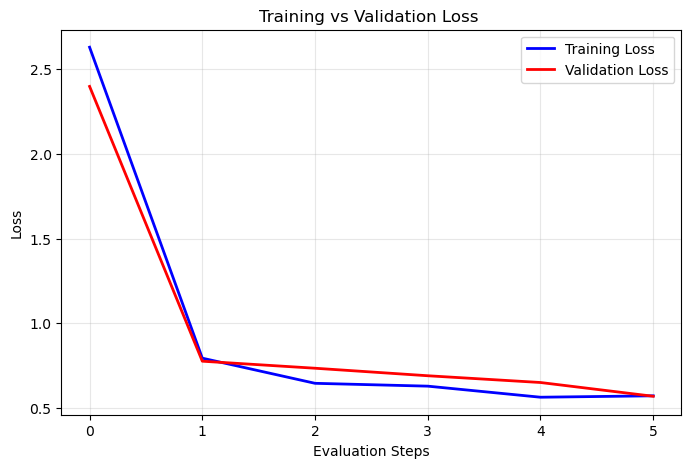

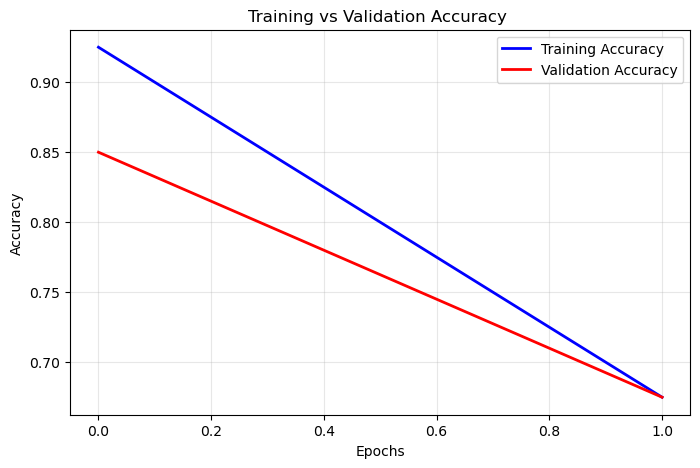

In [36]:
# Plot just losses
def plot_losses(train_losses, val_losses, title_suffix=""):
    plt.figure(figsize=(8, 5))
    x_vals = range(len(train_losses))
    plt.plot(x_vals, train_losses, 'b-', linewidth=2, label='Training Loss')
    plt.plot(x_vals, val_losses, 'r-', linewidth=2, label='Validation Loss')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Loss')
    plt.title(f'Training vs Validation Loss {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Plot just accuracies
def plot_accuracies(train_accs, val_accs, title_suffix=""):
    plt.figure(figsize=(8, 5))
    x_vals = range(len(train_accs))
    plt.plot(x_vals, train_accs, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(x_vals, val_accs, 'r-', linewidth=2, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training vs Validation Accuracy {title_suffix}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Usage
plot_losses(train_losses, val_losses)
plot_accuracies(train_accs, val_accs)

In [41]:
"""
    * This code evaluates your fine-tuned model’s accuracy on three datasets—training, validation, and test.
"""

train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f'Training accuracy: {train_accuracy*100:.2f}%')
print(f'Validation accuracy: {val_accuracy*100:.2f}%')
print(f'Test accuracy: {test_accuracy*100:.2f}%')

Training accuracy: 74.42%
Validation accuracy: 68.46%
Test accuracy: 76.33%


In [45]:
"""
    * This function classifies a single text string (e.g., an email or SMS) as spam or not spam using a fine-tuned GPT-2 model.
     - text: The input string to classify.
     - model: The fine-tuned GPT-2 model for classification.
     - tokenizer: Converts text into numerical tokens.
     - device: Indicates whether to run on GPU ('cuda') or CPU.
     - max_length: Maximum number of tokens allowed for input.
     - pad_token_id: ID used to pad shorter sequences (50256 is GPT-2’s padding/end-of-text token).
"""

def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    
    model.eval()

    # Converts the input string into a list of token IDs the model can understand.
    input_ids = tokenizer.encode(text)   

    """
       * supported_context_length: The maximum number of positions GPT-2 supports (e.g., 1024 tokens for GPT-2 small).
       * min(max_length, supported_context_length): Ensures the input sequence does not exceed.
         - The model’s limit.
         - The user-defined max_length.
       * Truncates long texts to avoid errors.
       * model.config.n_positions is the maximum sequence length GPT-2 supports (e.g., 1024).
    """
    supported_context_length = model.config.n_positions
    input_ids = input_ids[:min(max_length, supported_context_length)]

    """ Pad sequences to uniform length: (important for batching in PyTorch).
        If the input is shorter than max_length, pad it with the pad_token_id so all sequences have equal length.
    """
    input_ids += [pad_token_id] * (max_length - len(input_ids))

    """
        * Convert to tensor and add batch dimension.
        * Converts the list of token IDs into a PyTorch tensor on the correct device (GPU/CPU).
        * .unsqueeze(0): Adds a batch dimension, so the shape becomes (1, max_length).
    """
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    # Turns off gradient calculations to speed up inference and save memory, since we’re not training here.
    with torch.no_grad(): 
        output = model(input_tensor).logits
        logits = output[:, -1, :]     # [:, -1, :]: Selects only the last token’s logits for classification.
    """
        * torch.argmax(logits, dim=-1): Finds the class with the highest probability.
        * .item(): Converts the PyTorch scalar to a Python integer.
        * Returns "spam" if the predicted class index is 1; otherwise "not spam".
    """
    predicted_label = torch.argmax(logits, dim=-1).item()

    return 'spam' if predicted_label == 1 else 'not spam' 

In [46]:
text_1 = (
    'You are a winner you have been specially'
    ' selected to receive $1000 cash or a $2000 award.'
)

print(classify_review(text_1, model, tokenizer, device, max_length=train_dataset.max_length))

spam


In [47]:
text_2 = (
    'Hey, can you come to the University? '
)

print(classify_review(text_2, model, tokenizer, device, max_length=train_dataset.max_length))

not spam


In [50]:
# --------------------------
# 5. Save the fine-tuned model
# --------------------------
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, "gpt2_finetuned_classification.pth")

print("Fine-tuning completed and saved to gpt2_finetuned_classification.pth!")

Fine-tuning completed and saved to gpt2_finetuned_classification.pth!


In [51]:

# 1. Recreate the same model architecture you used for training
model_2 = GPT2LMHeadModel.from_pretrained("gpt2")

# Replace the LM head for classification (2 classes)
model_2.lm_head = torch.nn.Linear(model_2.config.n_embd, 2)

# 2. Move model to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_2.to(device)

# 3. Recreate the optimizer (same hyperparameters as training)
optimizer = torch.optim.AdamW(model_2.parameters(), lr=5e-5, weight_decay=0.1)

# 4. Load the checkpoint
checkpoint = torch.load("gpt2_finetuned_classification.pth", map_location=device)
model_2.load_state_dict(checkpoint["model_state_dict"], strict=False)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

model_2.eval()
print("Model and optimizer successfully restored!")


Model and optimizer successfully restored!


In [52]:
print(model_2)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=2, bias=True)
)


In [53]:
# To evaluate the loaded model to classify a text as smap or not spam.
# Using our previously implemented function classify_review as follow:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    
    model.eval()

    # Converts the input string into a list of token IDs the model can understand.
    input_ids = tokenizer.encode(text)   
    
    supported_context_length = model.config.n_positions
    input_ids = input_ids[:min(max_length, supported_context_length)]

    input_ids += [pad_token_id] * (max_length - len(input_ids))

    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0)

    with torch.no_grad(): 
        output = model(input_tensor).logits
        logits = output[:, -1, :]     # [:, -1, :]: Selects only the last token’s logits for classification.
        
    predicted_label = torch.argmax(logits, dim=-1).item()

    return 'spam' if predicted_label == 1 else 'not spam' 

In [54]:
text_3 = ("ngratulations! You have won a $1000 Walmart gift card. Claim your prize now!")

print(classify_review(text_3, model, tokenizer, device, max_length=120))

spam
